# Homework 10: Neural Networks
by Yousif Khaireddin

**Due date**: April 28, Wednesday by 11:59pm


## Setup

To run and solve this assignment, you must have access to a working Jupyter Notebook installation. We recommend Google Colab. If you are already familiar with Jupyter and have your own installation, you may use it; however, you will have to tweak Colab-specific commands we've entered here (for example, file uploads).

To use Google Colab:

1. Download this `ipynb` file.
2. Navigate to https://colab.research.google.com/ and select `Upload` in the pop-up window.
3. Upload this file. It will then open in Colab.

The below statements assume that you have already followed these instructions. If you need help with Python syntax, NumPy, or Matplotlib, you might find Week 1 discussion material useful.

To run code in a cell or to render Markdown+LaTeX press Ctrl+Enter or "`Run`" button above. To edit any code or text cell, double-click on its content. Put your solution into boxes marked with **`[double click here to add a solution]`** and press Ctrl+Enter to render text. You can add cells via `+` sign at the top left corner.

**Submission instructions**: please upload your completed solution file as well as a scan of any handwritten answers to Gradescope by **April 28th at midnight**..

## **Question 1:** Useful Functions and Setup


In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Loading Dataset

Using the datasets module within torchvision, download the MNIST dataset.
1. Download both the training dataset as well as the testing dataset.
2. Using _torch.utils.data.random_split_ seperate the training dataset into 50000 training samples and 10000 validation samples 

In [ ]:
# Training and validation data
train_dataset = datasets.MNIST("", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Testing data
test_dataset = datasets.MNIST("", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw




Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw




Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw




Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
print("Number of Training Samples:", len(train_dataset), sep='\t')
print("Number of Validation Samples:", len(val_dataset), sep='\t')
print("Number of Testing Samples:", len(test_dataset), sep='\t')

Number of Training Samples:	50000
Number of Validation Samples:	10000
Number of Testing Samples:	10000


Build your dataloaders using the datasets above. Make sure to use a batchsize of 64 and to shuffle your dataset.

In [ ]:
# Creating Dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

print("Number of Training Batches:", len(trainloader), sep='\t')
print("Number of Validation Batches:", len(valloader), sep='\t')
print("Number of Testing Batches:", len(testloader), sep='\t')

Number of Training Batches:	782
Number of Validation Batches:	157
Number of Testing Batches:	157


### Important functions

Complete the function `train(net, dataloader, criterion, optimizer)` which will train a given network for 1 whole epoch using a given dataloader.

This function will iterate through the dataloader, compute the network outputs, the loss, backpropogate to update the networks weights, and return the accuracy and average loss across the dataloader

Ensure to setup the network in training mode using the .train() attribute built by pytorch.

In [ ]:
def train(net, dataloader, criterion, optimizer):
    net = net.train()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # store / calculate performance metrics (acc, loss)
        loss_tr += loss.item()
        
        for idx, j in enumerate(outputs):
            if torch.argmax(j) == labels[idx]:
                correct_count += 1
            n_samples +=1
        
    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples

    return acc, loss

Complete the function `evaluate(net, dataloader, criterion)` which will evauate a given network's performance across a given dataloader

This function will iterate through the dataloader, compute the network outputs, the loss, and return the accuracy and average loss across the dataloader.

Ensure to setup the network in validation mode using the .eval() attribute built by pytorch.

In [ ]:
def evaluate(net, dataloader, criterion):
    net = net.eval()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # compute network predictions
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate performance metrics (acc, loss)
        loss_tr += loss.item()
        
        for idx, j in enumerate(outputs):
            if torch.argmax(j) == labels[idx]:
                correct_count += 1
            n_samples +=1

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples

    return acc, loss

Complete the function `count_parameters(model)` which should count the number of trainable parameters in a network.

In [ ]:
def count_parameters(model):

    count = sum(p.numel() for p in model.parameters() if p.requires_grad)

    return count

The following function will be used to create plots of your performance metrics.


In [ ]:
def plot_metrics(train_acc, train_loss, val_acc, val_loss):
    plt.figure()
    plt.plot(train_acc, 'g', label='Training Acc')
    plt.plot(val_acc, 'b', label='Validation Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(train_loss, 'g', label='Training Loss')
    plt.plot(val_loss, 'b', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

## **Question 2:** Dense Networks

**Note:**
In solving the following sections, it is possible very likely that your results do not match ours exactly. This is due to the randomization in initilizations. What is important is that they are within the margins we set when defining the problem. 

### Initial Performance

Recall from the discussion session, we provided you with the following fully connected (dense) network.


In [ ]:
class Dense(nn.Module):
    # What does your model contain
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)    # 10 classes
    
    # This is how data moves when passed to your model
    def forward(self, x):
        x = x.view(-1, 28*28)   # Flatten
        x = F.relu(self.fc1(x)) # Pass through layers
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)   # soft max 
        
        return x

dense = Dense().to(device)

print("Model Architecture")
print(dense)
print("Number of parameters:", count_parameters(dense))

Model Architecture
Dense(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)
Number of parameters: 59210


Complete the following code to train the network above for 3 epochs.
1. For your optimizer, use stochatic gradient descent with a learning rate of 0.001
2. For your criterion (loss function) use Cross Entropy Loss (the one built by pytorch)

**Note:** We are expecting bad performance here using the above mentioned parameters.

In [ ]:
optimizer = optim.SGD(dense.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_acc, train_loss = [],[]
val_acc, val_loss = [],[]

print("Training on", device)
for epoch in range(3):
    
    acc_tr, loss_tr = train(dense, trainloader, criterion, optimizer)
    train_loss.append(loss_tr)
    train_acc.append(acc_tr)

    acc_v, loss_v = evaluate(dense, valloader, criterion)
    val_loss.append(loss_v)
    val_acc.append(acc_v)

    print('Epoch %2d' % (epoch + 1),
            'Train Accuracy: %2.2f %%' % acc_tr,
            'Val Accuracy: %2.2f %%' % acc_v,
            sep='\t\t')

Training on cuda:0
Epoch  1		Train Accuracy: 13.55 %		Val Accuracy: 14.23 %
Epoch  2		Train Accuracy: 18.82 %		Val Accuracy: 15.45 %
Epoch  3		Train Accuracy: 13.12 %		Val Accuracy: 11.87 %


Plot your performance using `plot_metrics` then evaluate your performance on the testloader / testset



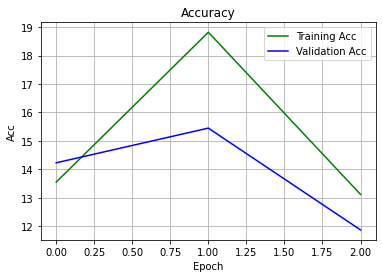

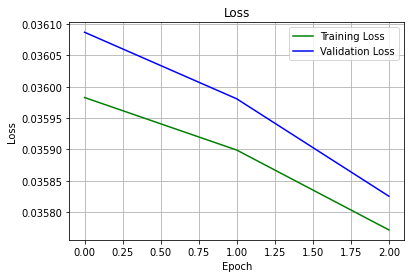

Test Accuracy: 11.56 %		Test Loss: 0.035795


In [ ]:
plot_metrics(train_acc, train_loss, val_acc, val_loss)

acc_test, loss_test = evaluate(dense, testloader, criterion)
print('Test Accuracy: %2.2f %%' % acc_test,
        'Test Loss: %2.6f' % loss_test,
        sep='\t\t')

### Tuned Performance

Vary any parameters you would like in the model's architecture (number of layers, hidden units, activation functions) or the training parameters (number of epochs, optimizer, learning rate, weight decay, momentum) to improve your initial performance. 

**Notes and requirements:** 
- The minimum acceptable test accuracy is 90%
- If you run your network multiple times it is possible to get very different results with each run. This is due to the random initializations.
- You are required to note down 5 significant changes you have experimented with and explain how these changes impacted your performance and your understanding as to why this is the case.
- Keep your best performing model / training method and create the same plots and testing performance from above. 

In [ ]:
class TunedDense(nn.Module):
    # What does your model contain
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Sigmoid()
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 10)    # 10 classes
    
    # This is how data moves when passed to your model
    def forward(self, x):
        x = x.view(-1, 28*28)   # Flatten
        x = self.fc1(x)   # Pass through layers
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.relu(self.fc4(x))
        x = F.log_softmax(self.fc5(x), dim=1)   # soft max
        
        return x

tuned_dense = TunedDense().to(device)

print("Model Architecture")
print(tuned_dense)
print("Number of parameters:", count_parameters(tuned_dense))

Model Architecture
TunedDense(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Sigmoid()
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
)
Number of parameters: 59210


In [ ]:
optimizer = optim.SGD(tuned_dense.parameters(), lr=0.002, momentum=0.2)
criterion = nn.CrossEntropyLoss()

train_acc, train_loss = [],[]
val_acc, val_loss = [],[]

print("Training on", device)
for epoch in range(12):
    
    acc_tr, loss_tr = train(tuned_dense, trainloader, criterion, optimizer)
    train_loss.append(loss_tr)
    train_acc.append(acc_tr)

    acc_v, loss_v = evaluate(tuned_dense, valloader, criterion)
    val_loss.append(loss_v)
    val_acc.append(acc_v)

    print('Epoch %2d' % (epoch + 1),
            'Train Accuracy: %2.2f %%' % acc_tr,
            'Val Accuracy: %2.2f' % acc_v,
            sep='\t\t')

Training on cuda:0
Epoch  1		Train Accuracy: 11.22 %		Val Accuracy: 11.64
Epoch  2		Train Accuracy: 19.25 %		Val Accuracy: 35.86
Epoch  3		Train Accuracy: 57.19 %		Val Accuracy: 64.31
Epoch  4		Train Accuracy: 76.78 %		Val Accuracy: 74.54
Epoch  5		Train Accuracy: 83.96 %		Val Accuracy: 85.36
Epoch  6		Train Accuracy: 88.08 %		Val Accuracy: 87.77
Epoch  7		Train Accuracy: 89.55 %		Val Accuracy: 90.41
Epoch  8		Train Accuracy: 90.63 %		Val Accuracy: 91.25
Epoch  9		Train Accuracy: 91.08 %		Val Accuracy: 92.09
Epoch 10		Train Accuracy: 91.49 %		Val Accuracy: 92.11
Epoch 11		Train Accuracy: 91.70 %		Val Accuracy: 92.86
Epoch 12		Train Accuracy: 92.10 %		Val Accuracy: 93.72


Plot your peroformance using `plot_metrics` then evaluate your performance on the testloader / testset



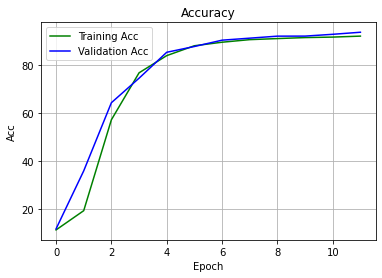

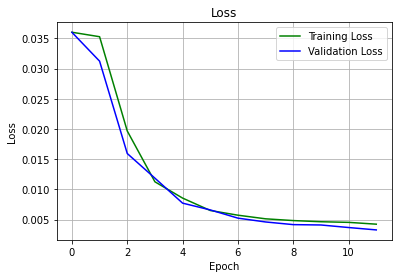

Test Accuracy: 90.23 %		Test Loss: 0.005195


In [ ]:
plot_metrics(train_acc, train_loss, val_acc, val_loss)

acc_test, loss_test = evaluate(tuned_dense, testloader, criterion)
print('Test Accuracy: %2.2f %%' % acc_test,
        'Test Loss: %2.6f' % loss_test,
        sep='\t\t')

**Experiementations and explainations:**



*   Changed learning rate to 0.002 - The learning rate affects the speed and accuracy of convergence in Stochastic Gradient Descent, as we saw with earlier homework assignments. Too small of a learning rate slows down convergence and too large of a learning rate will cause parameters to "bounce" back and forth. This proved to be a good learning rate value that led to successful convergence and accurate performance.
*   Set momentum to 0.2 - This helps the network to find the gradients in the right direction quicker. This improves the performance because it leads to faster convergence.
*   Changed the number of epochs to 12 - This gives the network more time to  learn on the training set. With each epoch, it is able to become more accurate. Therefore, the trained network is more accurate with the test set.
*   Added another layer (a sigmoid layer) - Adding another layer created a deeper neural network. Each layer is able to learn more complex information on the original data. This results in better learning and higher accuracy.
*   In the forward pass, I alternated between linear and ReLU layers. - This alternates linear and non-linear layers. This is better than having just all linear or all non-linear layers because a non-linear layer like ReLU that performs on the output from a linear layer is able to learn more complex data (like non-linear data or data with high dimensions). This is also more effective than having all linear layers because this would just result in a linear transformation. Therefore, alternating linear and non-linear layers resulted in higher accuracy because it allowed better learning on complex data.








## **Question 3:** Convolutional  Neural Networks



Using pytorch, build a 2d convolutional neural network with the following architecture.

1. 2D Convolution mapping the 1 x L x W input to 64 feature maps
2. 2D Convolution mapping the 64 x L x W features to 32 feature maps

3. Flatten the output
3. A dense layer mapping the flattened output to 16 nodes
4. A final dense layer mapping the 16 nodes to 10 classes

Each convolutional layer should be followed by a relu activation function then a 2D maxpool of `kernel_size` 2 and `stride` of 2

Each dense layer should be followed by a relu activation

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3)
        self.fc1 = nn.Linear(800, 16)   # flattened output to 16 nodes
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 10)    # 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        
        return x

cnn = CNN().to(device)

print("Model Architecture")
print(cnn)
print("Number of parameters:", count_parameters(cnn))

Model Architecture
CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
)
Number of parameters: 32362


Complete the following code to train the network above for 10 epochs.
1. For your optimizer, use stochatic gradient descent (you may change this later if you would like)

2. For your criterion (loss function) use Cross Entropy Loss (the one built by pytorch)

**Notes and requirements:** 
- The minimum acceptable test accuracy is 90%
- If you run your network multiple times it is possible to get very different results with each run. This is due to the random initializations.
- You are welcome to experiment with the CNN architecture and anything else you want. You are required to experiment with different values for `learning_rate`, `momentum`, and `weight_decay` in your optimizer to improve your performance.
- Note down your experimentations and explain how these changes impacted your performance and your understanding as to why this is the case.
- Keep your best performing model / training method and create the same plots and testing performance as before.

In [ ]:
optimizer = optim.SGD(cnn.parameters(), lr=0.0015, momentum=0.2, weight_decay=0.2)
criterion = nn.CrossEntropyLoss()

train_acc, train_loss = [], []
val_acc, val_loss = [], []

print("Training on", device)
for epoch in range(10):
    
    acc_tr, loss_tr = train(cnn, trainloader, criterion, optimizer)
    train_loss.append(loss_tr)
    train_acc.append(acc_tr)

    acc_v, loss_v = evaluate(cnn, valloader, criterion)
    val_loss.append(loss_v)
    val_acc.append(acc_v)

    print('Epoch %2d' % (epoch + 1),
            'Train Accuracy: %2.2f %%' % acc_tr,
            'Val Accuracy: %2.2f' % acc_v,
            sep='\t\t')

Training on cuda:0
Epoch  1		Train Accuracy: 9.83 %		Val Accuracy: 13.00
Epoch  2		Train Accuracy: 25.39 %		Val Accuracy: 35.34
Epoch  3		Train Accuracy: 54.40 %		Val Accuracy: 60.69
Epoch  4		Train Accuracy: 68.75 %		Val Accuracy: 68.42
Epoch  5		Train Accuracy: 82.41 %		Val Accuracy: 82.34
Epoch  6		Train Accuracy: 89.55 %		Val Accuracy: 87.63
Epoch  7		Train Accuracy: 92.16 %		Val Accuracy: 89.80
Epoch  8		Train Accuracy: 93.20 %		Val Accuracy: 87.48
Epoch  9		Train Accuracy: 83.46 %		Val Accuracy: 88.03
Epoch 10		Train Accuracy: 92.04 %		Val Accuracy: 91.29


Plot your peroformance using `plot_metrics` then evaluate your performance on the testloader / testset

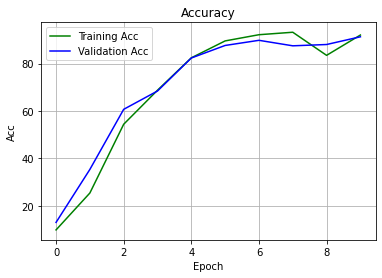

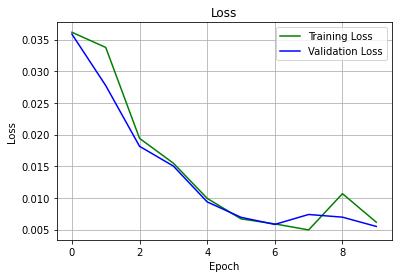

Test Accuracy: 91.50 %		Test Loss: 0.004733


In [ ]:
plot_metrics(train_acc, train_loss, val_acc, val_loss)

acc_test, loss_test = evaluate(cnn, testloader, criterion)
print('Test Accuracy: %2.2f %%' % acc_test,
        'Test Loss: %2.6f' % loss_test,
        sep='\t\t')

**Experiementations and explainations:**

After experimenting, I set the learning rate to 0.0015, the momentum to 0.2, and the weight decay to 0.2. I found that accuracy decreased when I increased the learning rate to 0.002 or 0.003. I varied momentum between 0.08 and 0.4 and found 0.2 to be the most optimal. I also varied weight decay between 0.1 and 0.5 and found 0.2 to be the most optimal. The learning rate determines how much the weights are updated, momentum affects the speed of convergence, and the weight decay provides an L2 penalty, so these parameters for the optimizer needed to be properly tuned to achieve a higher accuracy.

I also experimented with adding another dense layer in the CNN. I added a softmax layer, which is non-linear and rescales the values between 0 and 1. Since softmaxes are usually used in the ouput layer to classify data into multiple categories, this was useful for our network since it is performing on MNIST data.


## **Question 4:** Compare your results


Compare the cnn and dense networks your have built in terms of performance, runtime, accuracy, and any other factors you think are note worthy.

**Answer:**

Comparing the CNN to the dense network from problem 3, the CNN was able to achieve a higher accuracy with fewer parameters. The CNN had 32362 parameters while the TunedDense network had 59210 parameters. My CNN also ran for less epochs than my TunedDense network did. Both networks alternated between linear and non-linear (ReLU) layers, but the CNN also had convolutional layers. In CNNs, the convolutional layers act as image filters and can capture spatial information (they are invariant to translation). The convolutional layers also reduce the complexity, which has a positive impact on performance and runtime. Furthermore, CNNs work better than dense networks when training on image data. Since we are using MNIST data, the CNN would perform better.
